<h1 id="punto-1">Punto 1</h1>

## Punto 1.1 <a id="punto-1-1"></a>

In [51]:
import numpy as np
import pandas as pd


df = pd.read_csv(r"../data/raw/casas_dev.csv") 

df.sample(5, random_state=42)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0


In [52]:

df.describe(include='all')


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,533.598889,NaN,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,NaN,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,NaN,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,NaN,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,NaN,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,NaN,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000


Algo que es particular resaltar es que la feature ```area_units``` no tiene sentido que se mantenga. Podemos realizar una conversión y eliminar está feature.

Convertimos la feature ```sqft``` a ```m2``` y eliminamos la columna ```area_units```

In [53]:
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df = df.drop('area_units', axis=1)

df.describe(include='all')

,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
mean,94.794747,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,30.220560,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,74.000000,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,92.995903,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,111.264314,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000
max,237.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000


Hacemos un análisis de las features que contienen NaNs.

In [54]:
from utils.data import get_nan_features

nan_features = get_nan_features(df) 


print("Features con valores nulos y su cantidad de valores nulos: ", nan_features.items())


Features con valores nulos y su cantidad de valores nulos:  dict_items([('age', 130), ('rooms', 72)])


Observamos que las features con ```NaNs``` son ```age``` y ```room```.

Obtenemos la distribucion empirica de la feature ```rooms``` y de ```age```

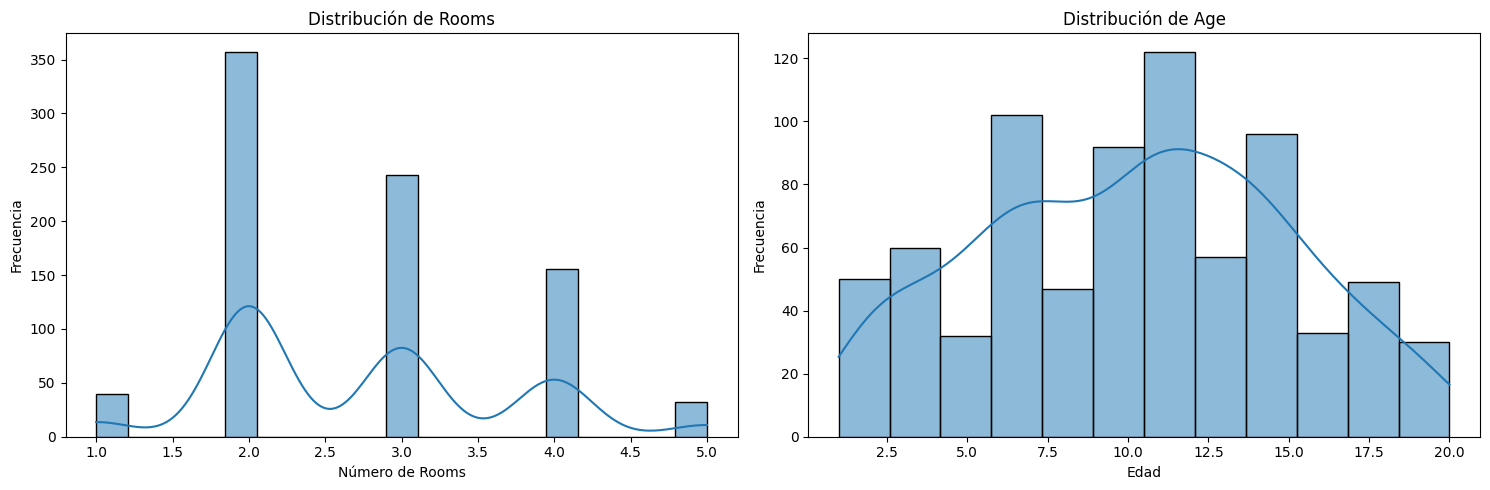

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['rooms'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Rooms')
axes[0].set_xlabel('Número de Rooms')
axes[0].set_ylabel('Frecuencia')

sns.histplot(df['age'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Age')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que la media de ```roooms``` es ```2.737``` y que la media de ```age``` es ```10.212```. Podemos reemplazar en las muestras (filas) que tienen ```NaNs``` con la media. Esto es un proceso válido ya que al reemplazar los NaNs con la media, la variable conserva su escala original (no se generan valores fuera de rango ni se produce un sesgo), lo que ayuda a mantener la consistencia de la información que aporta esa variable.

Sin embargo, no estamos teniendo en cuenta que nuestros datos pueden estar agrupados en diferentes grupos. Momentareamente dejaré esta media insertada en los datos faltantes, pero cabe recalcar que está relativamente MAL, puesto que estamos agarrando el promedio de TODOS los grupos de datos que se presentan. A motivos de hacer este TP que siga con el enunciado, se realizaran las modificaciones en el inciso 4. 

Otra solución sería utilizar un modelo NO LINEAL para predecir estas features, solución que excede este TP.

In [56]:

features_to_impute = ['rooms', 'age']


for feature in features_to_impute:

    mean_value = df[feature].mean()
    
    df[feature] = df[feature].fillna(mean_value)
    
    print(f'Imputando en {feature} con la media: {mean_value}')
    

print(df.head())

Imputando en rooms con la media: 2.7379227053140096
Imputando en age con la media: 10.212987012987012
         area  is_house  has_pool   age  price        lat        lon  rooms
0   58.993405         1         0  18.0  546.0  40.679064 -74.007844    2.0
1  102.007494         0         0   9.0  759.0  40.712839 -73.967750    3.0
2   61.966301         0         0   7.0  464.0  40.669863 -74.029414    2.0
3  127.000000         1         1  16.0  251.0 -34.600437 -58.415266    4.0
4  128.020334         0         0   8.0  963.0  40.722322 -73.983229    4.0


Guardamos el dataframe en un CSV.

In [57]:
df.to_csv(r"../data/processed/casas_dev.csv", index=False)

## Punto 1.2 <a id="punto-1-2"></a>



<div style="padding: 10px; border-radius: 5px;">
    <p>
        Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
        la relación entre las variables. Para esto, es útil el comando <code>pairplot</code>. 
        ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? 
        Se permite la creación de gráficos adicionales que considere relevantes.
    </p>
</div>


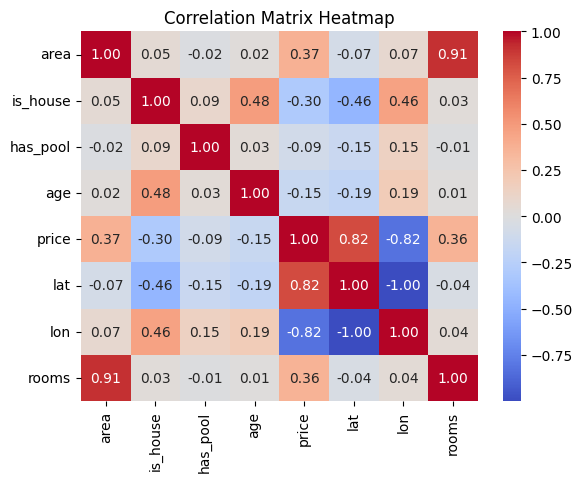

,area,is_house,has_pool,age,price,lat,lon,rooms
area,1.000000,0.047767,-0.020012,0.020607,0.371862,-0.071974,0.071787,0.907964
is_house,0.047767,1.000000,0.093175,0.482947,-0.298412,-0.459865,0.459664,0.029574
has_pool,-0.020012,0.093175,1.000000,0.033317,-0.088624,-0.146234,0.146399,-0.007955
age,0.020607,0.482947,0.033317,1.000000,-0.149007,-0.194795,0.194773,0.013094
price,0.371862,-0.298412,-0.088624,-0.149007,1.000000,0.822490,-0.822537,0.359635
lat,-0.071974,-0.459865,-0.146234,-0.194795,0.822490,1.000000,-0.999992,-0.040040
lon,0.071787,0.459664,0.146399,0.194773,-0.822537,-0.999992,1.000000,0.039892
rooms,0.907964,0.029574,-0.007955,0.013094,0.359635,-0.040040,0.039892,1.000000


In [58]:
import seaborn as sns 


# matriz de correlación
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

corr

Observamos que la variable **area** presenta una correlación muy alta de 0.91 con **rooms**, lo que es totalmente coherente, ya que a medida que aumenta la cantidad de habitaciones, la superficie total de la propiedad tiende a crecer. Además, la **latitud (lat)** muestra una fuerte correlación positiva de 0.82 con **price**, lo que sugiere que las propiedades ubicadas en zonas con mayor latitud tienden a tener precios más altos; en contraposición, la **longitud (lon)** tiene una correlación negativa de -0.82 con **price**, lo que indica que en las áreas donde la longitud es mayor, los precios son más bajos. Esto podría interpretarse como que existen zonas geográficas diferenciadas, donde la posición en el mapa influye significativamente en el valor de la propiedad. 

Por otro lado, se observa una correlación moderada de 0.48 entre **is_house** y **age**, lo que sugiere que las casas (frente a otros tipos de propiedades) tienden a ser más antiguas. Asimismo, **is_house** se relaciona moderadamente con las coordenadas: presenta una correlación de -0.46 con **lat** y de 0.46 con **lon**, lo que puede indicar que las casas se concentran en áreas geográficas específicas distintas a aquellas de otros inmuebles. 

Finalmente, resulta destacable la casi perfecta correlación negativa de -1.0 entre **lat** y **lon**, lo que implica que, dentro del rango de datos, a medida que aumenta la latitud, la longitud disminuye de forma casi lineal, reflejando probablemente una distribución geográfica particular de las propiedades. Estos patrones nos ayudan a entender que la ubicación y el tipo de inmueble son determinantes importantes en la configuración del precio y otras características de las viviendas en el dataset.

Podriamos clasificar las casas por zonas (clusters) en base a la latitud y longitud.

En el siguiente gráfico se observan en mayor detalle las relaciones entre las variables.

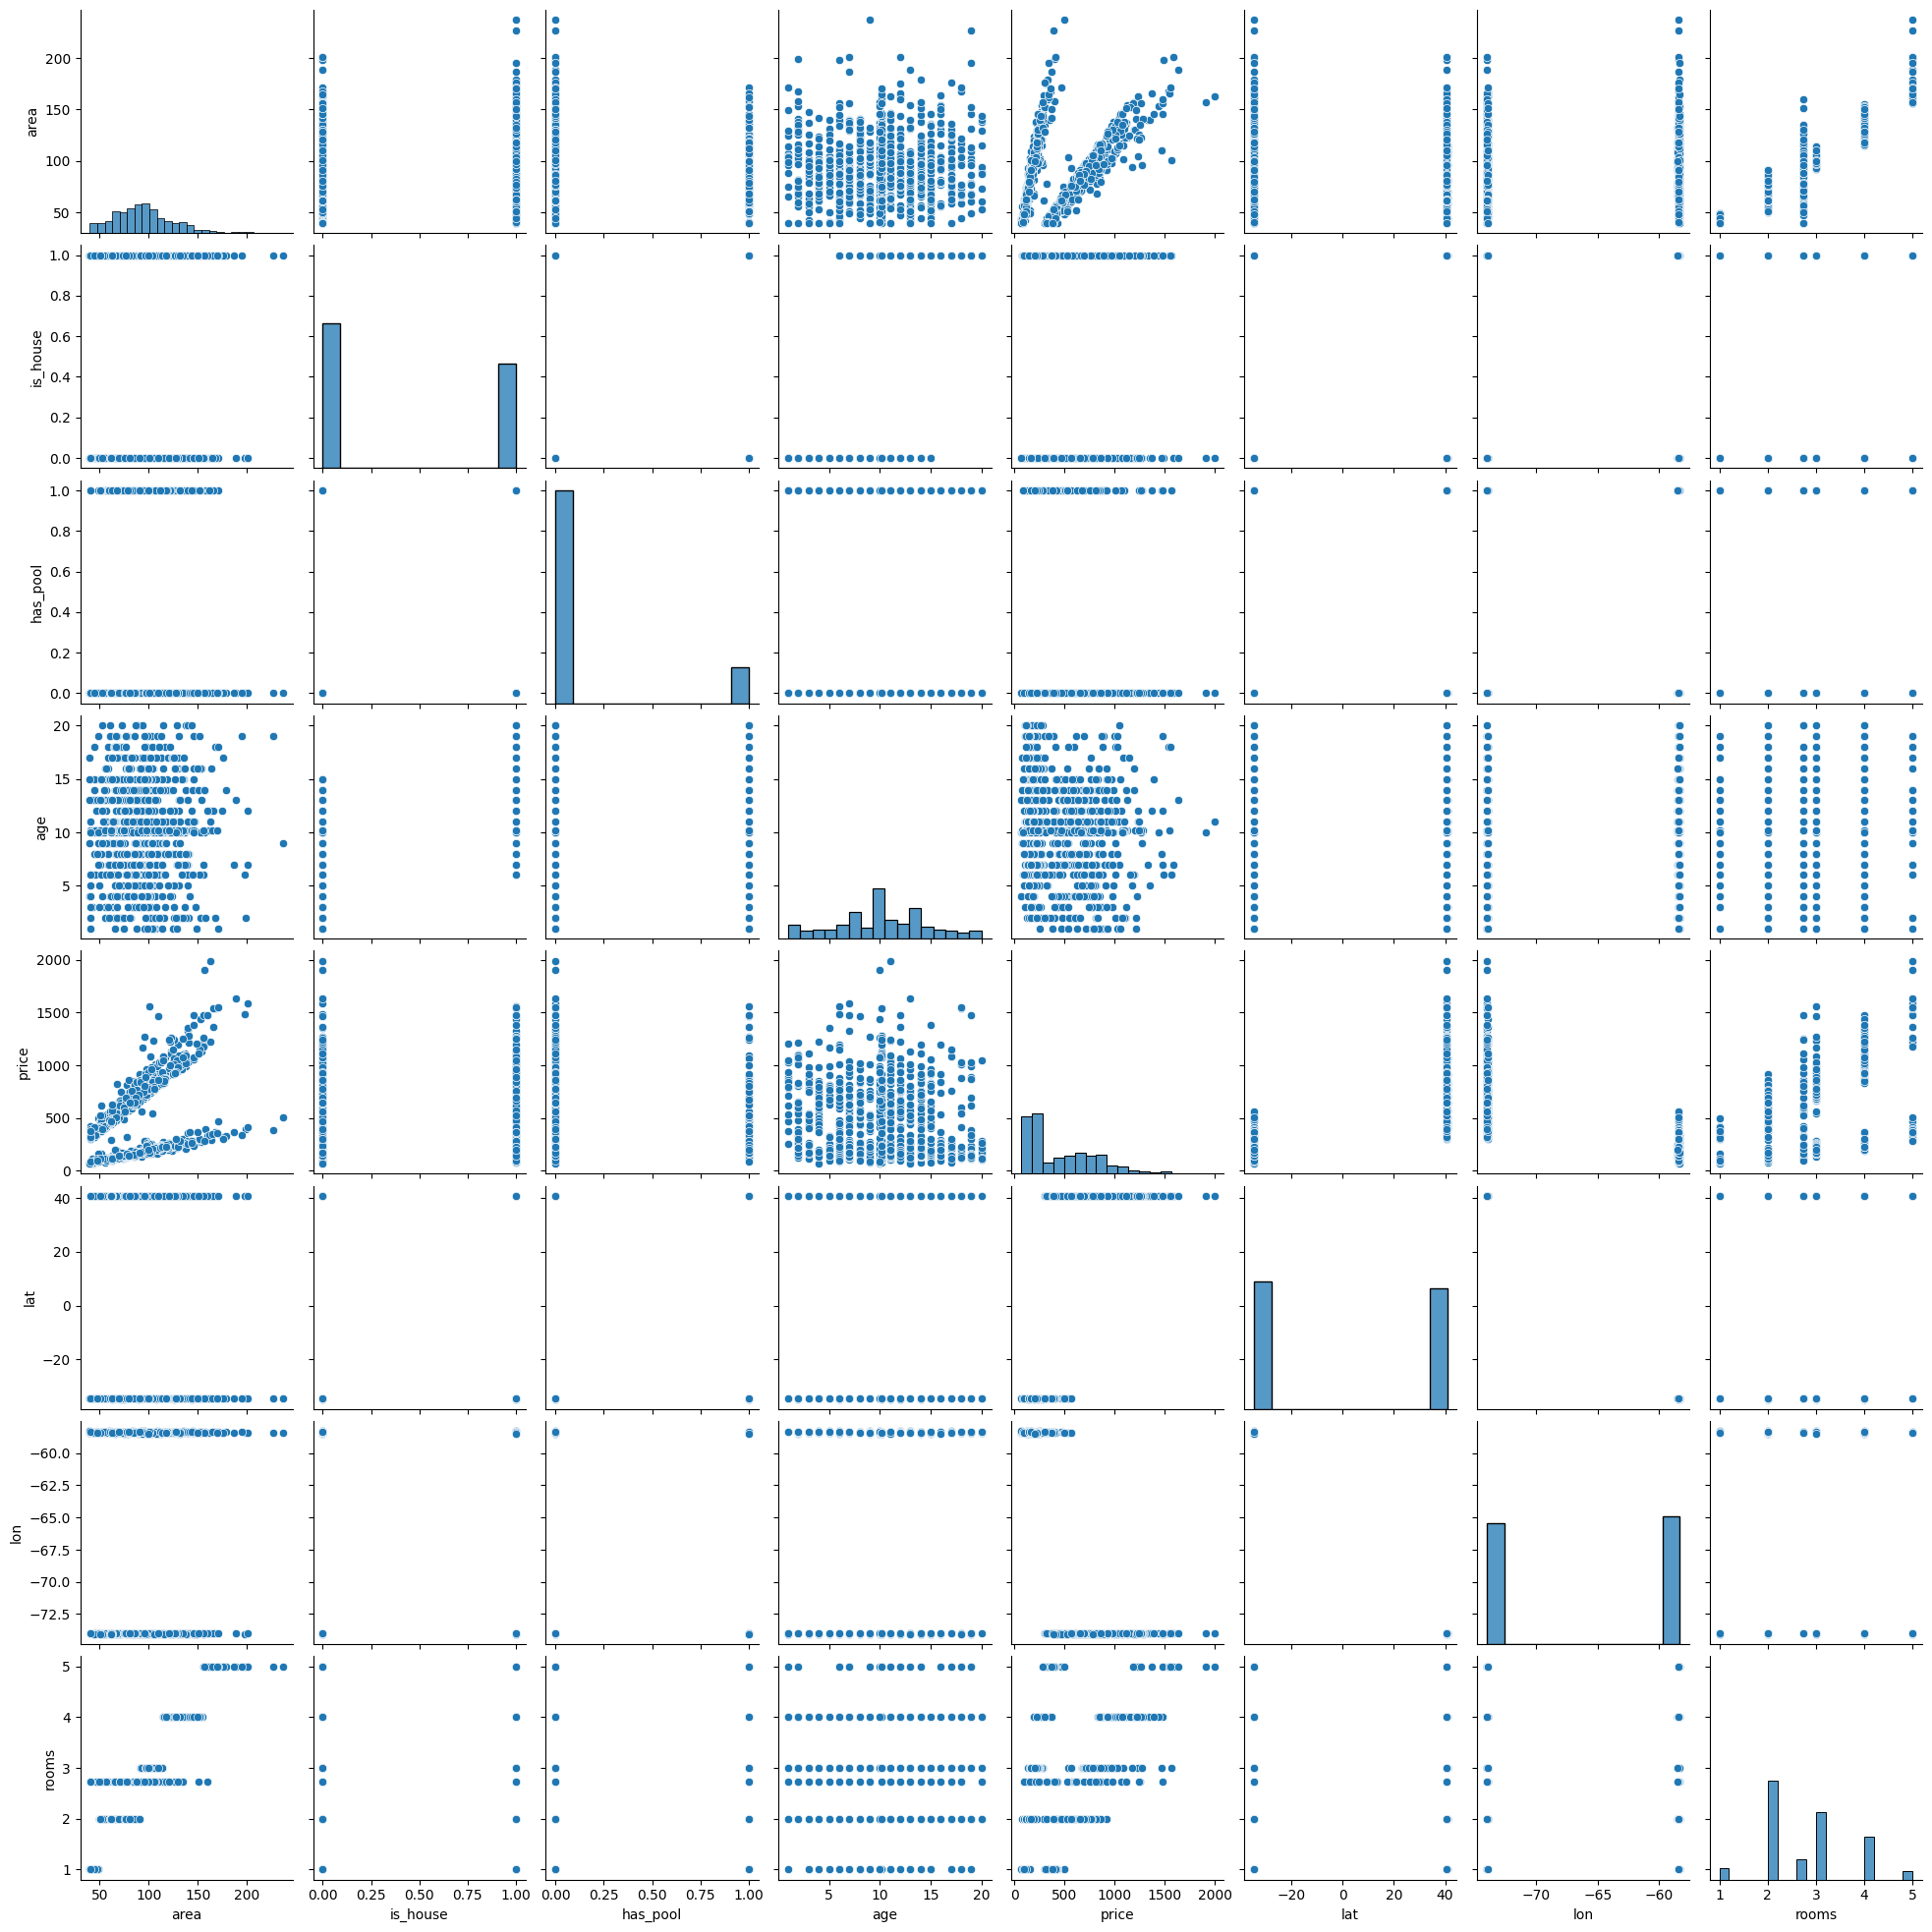

In [59]:
sns.pairplot(df)
plt.show()

Observamos en los gráficos de latitud y longitud como estan estrictamente correlacionados con una pendiente negativa. Parece haber 2 clusters en el mismo, caracteristica que explotaremos en el inciso 4. 

Por otro lado, en el grafico de area vs price notamos una correlacion positiva, lo que indicaria que a mayor area mayor es el precio, algo que es relativamente logico. Similarmente se nota este patron en el grafico de rooms vs price y rooms vs area.

Tambien notamos una correlacion positica entre latitud vs price, dandonos un indicador que ciertas zonas tienden a incrementar el valor de los inmuebles, mientras que la longitud vs price tiene una correlacion negativa, indicandonos

Por ultimo, notamos como, si el inmubele es una casa, tiende a tener mayor edad que aquellso que no



## Punto 1.3 <a id="punto-1-3"></a>


Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [60]:
from utils.data import split_test_train_with_label

df = pd.read_csv(r"../data/processed/casas_dev.csv")

X = df.drop('price', axis=1)
y = df['price']


X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12,normalize=True)


# Punto 2

### Todas las features (menos price)

#### Pseudo Inversa

In [61]:
from utils.model import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_linear_psinv_all = train_and_evaluate_model( # si no aplico log(y), el modelo es relativamente "malo"
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse",
                "loss": "mse"},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_all = results_linear_psinv_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11630.160150
R2: 0.904712
MAE: 83.190651
Método: pseudo_inverse
Intercept: 3677.5350

Coeficientes:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


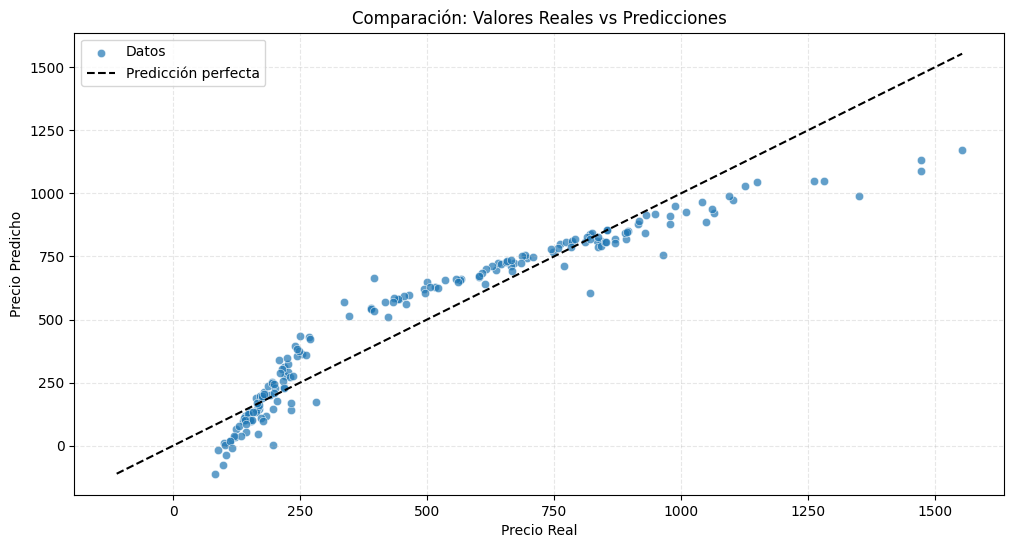

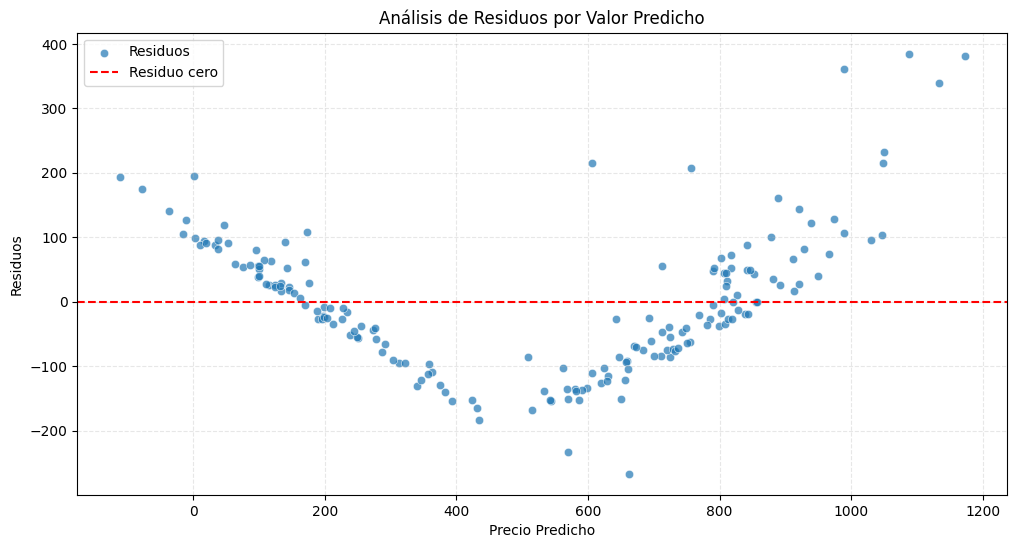

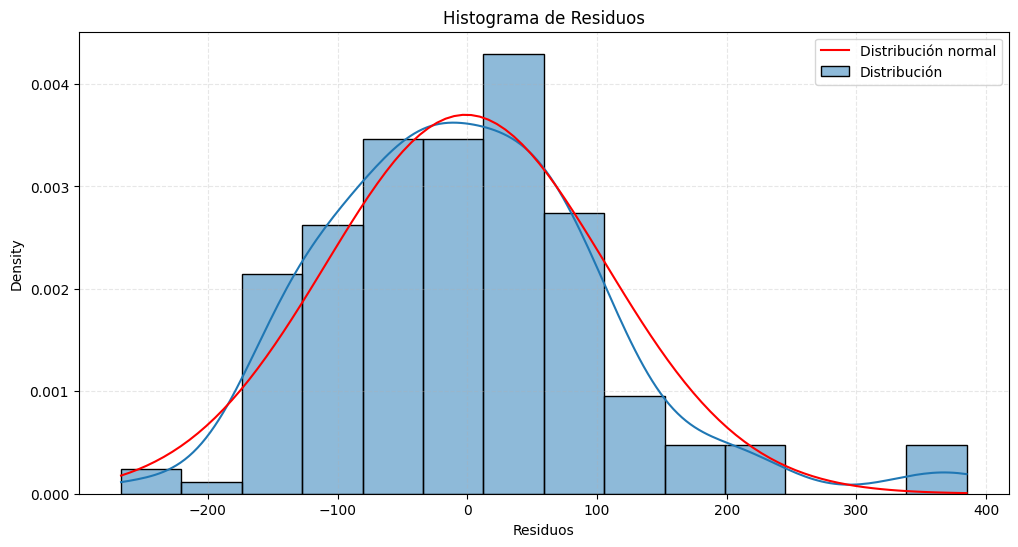

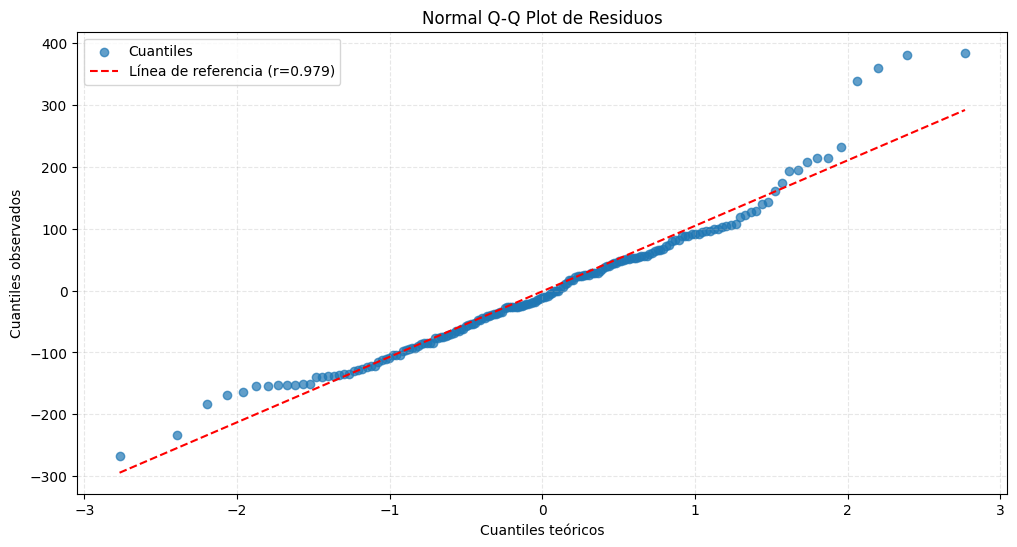

In [62]:
from utils.visuals import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}


figures_linear_psinv_all = visualize_regression_results(
    results_linear_psinv_all['y_test'],
    results_linear_psinv_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True
)



Los gráficos muestran en primer lugar, en el diagrama de valores predichos vs. residuos, que la varianza de los errores no se mantiene constante a lo largo de todo el rango de valores y se observa cierta curvatura empinada que sugiere una relación no capturada por el modelo o heterocedasticidad. Al mismo tiempo, el Q-Q plot (asumiendo una distribución normal) indica que, en general, los residuos se aproximan a la distribución normal, aunque se aprecian leves desvíos que podría deberse a la presencia de outliers. El histograma de residuos confirma que la mayoría se concentra cerca de cero pero existen valores atípicos que se extienden hacia la cola positiva. Conviene revisar si el modelo está capturando adecuadamente la forma funcional de las variables, por ejemplo, incluyendo términos polinómicos o interacciones en caso de relaciones no lineales. Ridge o Lasso pueden ayudar si hay multicolinealidad o sobreajuste, ya que estabilizan los coeficientes y reducen la varianza de las estimaciones, pero no resuelven de manera directa la heterocedasticidad. 

Estaría bueno hacer tests de heterocedasticidad.

#### Gradient Descent

In [63]:
from utils.model import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_gd_linear_all = train_and_evaluate_model(
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae']
    )

model_gd_linear_all = results_gd_linear_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11654.140146
R2: 0.904515
MAE: 83.430803
Método: gradient_descent
Intercept: 455.7167

Coeficientes:
------------------------------
area            | +139.8104
is_house        | +37.2665
has_pool        | +15.0462
age             | -14.7437
lat             | +155.9551
lon             | -155.8073
rooms           | +10.0213
Convergencia: Sí
Iteraciones: 1000/1000


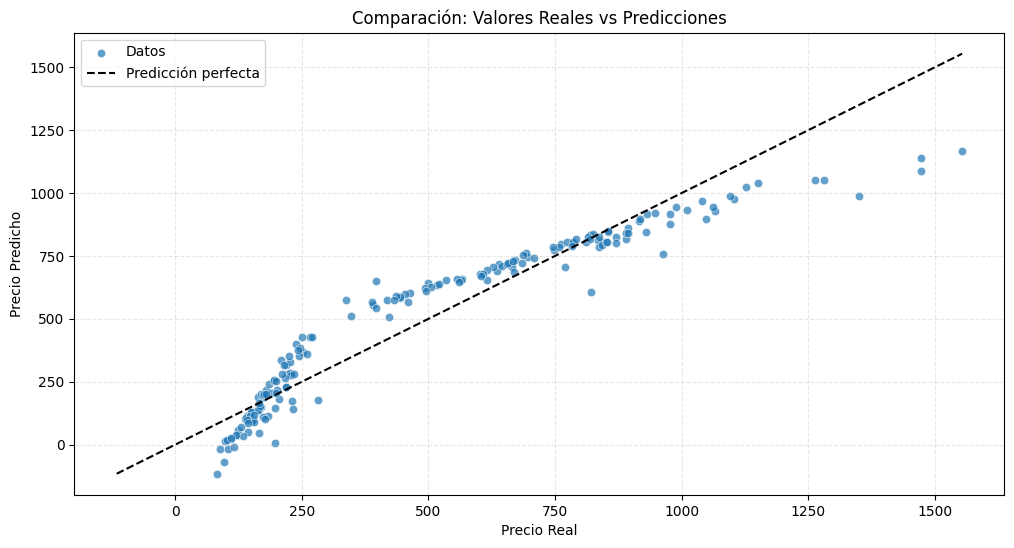

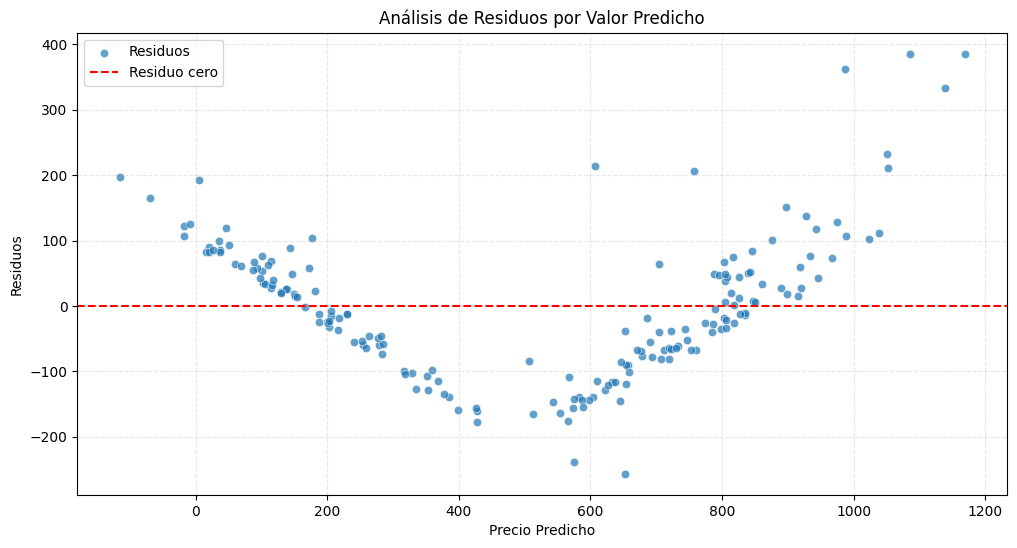

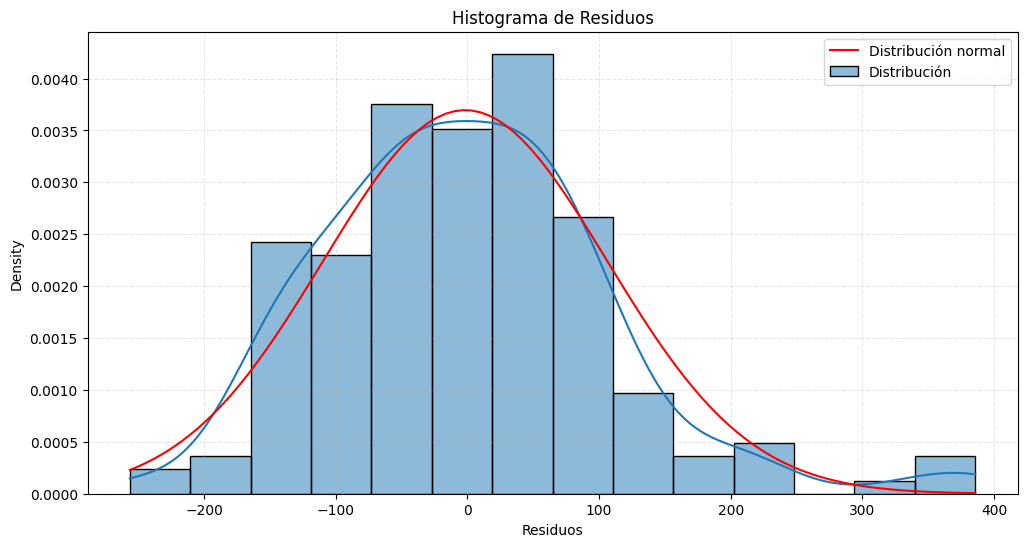

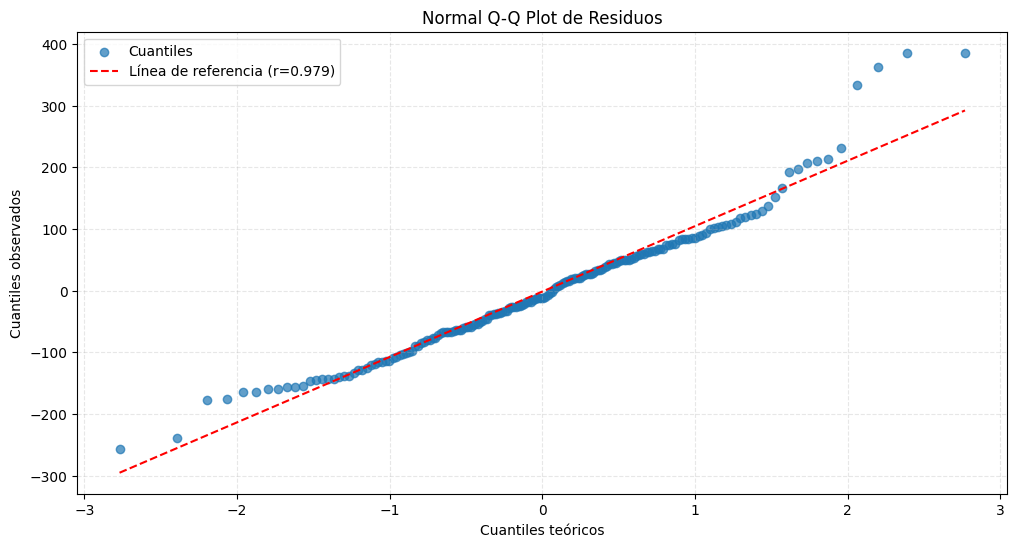

In [64]:
from utils.visuals import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}

figures = visualize_regression_results(
    results_gd_linear_all['y_test'],
    results_gd_linear_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=1
)





### 1 feature


Pseudo Inversa

In [65]:
from utils.model import train_and_evaluate_model

results_linear_psinv_area = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_area = results_linear_psinv_area["model"]


=== Model Evaluation (LinearRegressor) ===
MSE: 102728.297632
R2: 0.158327
MAE: 296.621040
Método: pseudo_inverse
Intercept: 75.5102

Coeficientes:
------------------------------
area            | +4.0167


Gradient descent


In [66]:
from utils.model import train_and_evaluate_model

results_gd_linear_area = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    feature_columns = ["area"],
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae'],
    verbose=True
)

model_gd_linear_area = results_gd_linear_area["model"]

results_gd_linear_area["normalization_params"]



=== Model Evaluation (LinearRegressor) ===
MSE: 102728.866581
R2: 0.158322
MAE: 296.621513
Método: gradient_descent
Intercept: 455.7119

Coeficientes:
------------------------------
area            | +123.4822
Convergencia: Sí
Iteraciones: 569/1000


{'mean': area    94.657096
 dtype: float64,
 'std': area    30.742739
 dtype: float64}

# Punto 3

## Punto 3.1

In [67]:
from utils.model import train_and_evaluate_model

df = pd.read_csv(r"../data/processed/casas_dev.csv")
df = df[df["is_house"] == 1]

results_area = train_and_evaluate_model( 
    df = df,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae'],
    verbose=False
)

model_area = results_area["model"]



### Punto 3.2

In [68]:
import pandas as pd

df_amanda = pd.read_csv(r"../vivienda_Amanda.csv")

df_amanda.loc[df_amanda['area_units'] == 'sqft', 'area'] = df_amanda['area'] * 0.092903
df_amanda['area_units'] = 'm2'  

df_amanda = df_amanda.drop('area_units', axis=1)



In [69]:
from utils.model import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_amanda = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse",
                "loss": "mse"},
    metrics=['mse', 'r2', 'mae']
)

model_amanda = results_amanda["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11630.160150
R2: 0.904712
MAE: 83.190651
Método: pseudo_inverse
Intercept: 3677.5350

Coeficientes:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


In [70]:
y_pred = model_linear_psinv_all.predict(df_amanda)

print(f"Valor estimado de la vivienda de Amanda: {y_pred[0]:.2f}")

Valor estimado de la vivienda de Amanda: 791.19


### Punto 3.3

3.3) En el dataset, ¿cuál es el valor promedio por metro cuadrado de una casa

In [71]:

area_cof = model_area.get_coef_dict()["area"]

print(f"El valor promedio por metro cuadrado de una casa es: {area_cof:.2f}")

El valor promedio por metro cuadrado de una casa es: 3.64


### Punto 3.4

Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

In [72]:

df = pd.read_csv(r"../data/processed/casas_dev.csv")    

precios = df.groupby('has_pool')['price'].mean()
print(precios)


has_pool
0    478.831169
1    391.369231
Name: price, dtype: float64


In [73]:
from utils.model import train_and_evaluate_model

df_pool_house = pd.read_csv(r"../data/processed/casas_dev.csv")
df_pool_house = df_pool_house[df_pool_house["is_house"] == 1]

results_pool_house = train_and_evaluate_model( 
    df = df_pool_house,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae'],
    verbose=False
)

model_pool_house = results_pool_house["model"]


house_pool_cof = model_pool_house.get_coef_dict()["has_pool"]



In [74]:
from utils.model import train_and_evaluate_model

df_pool_dept = pd.read_csv(r"../data/processed/casas_dev.csv")
df_pool_dept = df_pool_dept[df_pool_dept["is_house"] == 0]

results_pool_dept = train_and_evaluate_model( 
    df = df_pool_dept,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae'],
    verbose=False
)

model_pool_dept = results_pool_dept["model"]


dept_pool_cof = model_pool_dept.get_coef_dict()["has_pool"]




In [75]:
from utils.model import train_and_evaluate_model
from utils.visuals import visualize_regression_results

df_pool = pd.read_csv(r"../data/processed/casas_dev.csv")

results_pool_combined = train_and_evaluate_model( 
    df = df_pool,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae'],
    verbose=False
)

model_pool_combined = results_pool_combined["model"]


dept_pool_cof = model_pool_combined.get_coef_dict()["has_pool"]




In [76]:
from utils.visuals import compare_feature_impact

model_results = {
    "Departamentos": results_pool_dept,
    "Casas": results_pool_house,
    "Combinado": results_pool_combined
}

property_data = {
    "Departamentos": df_pool_dept,
    "Casas": df_pool_house,
    "Combinado": df_pool
}

impacts = compare_feature_impact(
    model_results_dict=model_results,
    property_dfs=property_data,
    feature_name='has_pool'
)

for model_name, impact_data in impacts.items():
    display_name = impact_data["display_name"]
    feature_impact = impact_data["absolute_impact"]
    avg_property_price = impact_data["average_price"]
    percentage_impact = impact_data["percentage_impact"]
    
    print(f"\nImpacto de agregar {display_name} para {model_name}:")
    print(f"- Valor absoluto agregado: ${feature_impact:.2f}")
    print(f"- Precio promedio de la propiedad: ${avg_property_price:.2f}")
    print(f"- Incremento porcentual sobre el promedio: {percentage_impact:.2f}%")


Impacto de agregar Pool para Departamentos:
- Valor absoluto agregado: $52.68
- Precio promedio de la propiedad: $554.10
- Incremento porcentual sobre el promedio: 9.51%

Impacto de agregar Pool para Casas:
- Valor absoluto agregado: $13.82
- Precio promedio de la propiedad: $344.26
- Incremento porcentual sobre el promedio: 4.01%

Impacto de agregar Pool para Combinado:
- Valor absoluto agregado: $45.13
- Precio promedio de la propiedad: $466.20
- Incremento porcentual sobre el promedio: 9.68%


La construcción de una pileta, según el análisis realizado mediante modelos predictivos que comparan el precio de propiedades con y sin esta característica, podría incrementar el valor de la propiedad en distintos porcentajes: en departamentos se observó un aumento promedio de USD 52.68 (9.51% sobre un precio promedio de USD 554.10), en casas un incremento de USD 13.82 (4.01% sobre USD 344.26) y, considerando un análisis combinado, un aumento de USD 45.13 (9.68% sobre USD 466.20); estos resultados se obtuvieron al “activar” la variable de pileta en el modelo y medir la diferencia en la predicción del precio, lo que aísla el impacto de esta amenidad, y es posible que la mayor apreciación en departamentos se deba a que, en contextos donde la oferta de amenities es más limitada o exclusiva, la incorporación de una pileta se perciba como un valor añadido significativamente mayor, mientras que en casas, donde las opciones de espacio y personalización son más amplias, el impacto relativo resulta menor.

# Punto 4

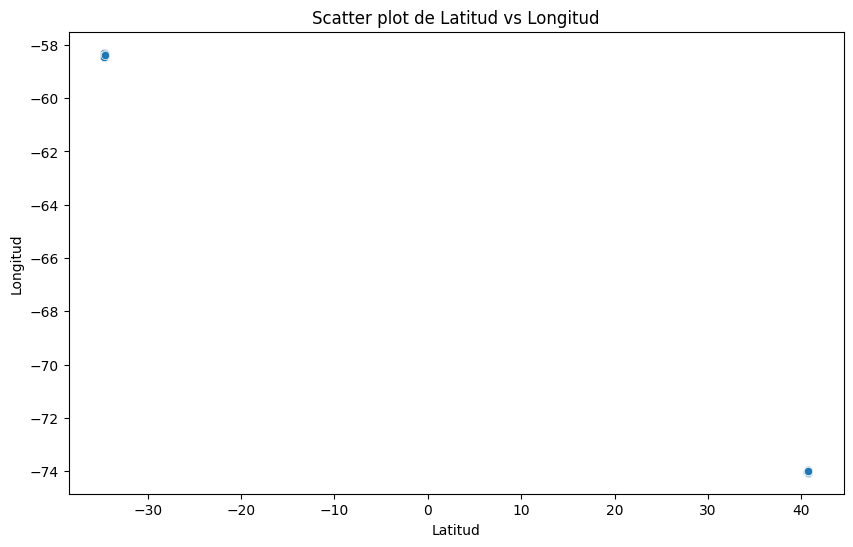

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon')
plt.title('Scatter plot de Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

In [78]:
from models.clustering.kmeans import KMeans
from utils.data import process_dataset

df = pd.read_csv(r"../data/processed/casas_dev.csv")


feature_ops = [
    {
        'name': 'area_per_room',
        'operation': lambda df: df['area'] / df['rooms']
    },
    {
        'name': 'pool_house',
        'operation': lambda df: df['has_pool'] * df['is_house']
    },
    {
        'name': 'house_area',
        'operation': lambda df: df['area'] * df['is_house']
    }
]

kmeans = KMeans(n_clusters=2)
results = process_dataset(
    df=df,
    kmeans_model=kmeans,
    feature_engineering_ops=feature_ops,
    features_to_impute=['age', 'rooms'],
    save_path=r"../data/processed/casas_dev_eng.csv"
)


processed_df = results['df']
location_data = results['df_pos']
zone_statistics = results['zone_stats']
feature_statistics = results['feature_stats']

processed_df.head()


,area,is_house,has_pool,age,price,rooms,location_zone,area_per_room,pool_house,house_area
0,58.993405,1,0,18.0,546.0,2.0,0,29.496703,0,58.993405
1,102.007494,0,0,9.0,759.0,3.0,0,34.002498,0,0.000000
2,61.966301,0,0,7.0,464.0,2.0,0,30.983151,0,0.000000
3,127.000000,1,1,16.0,251.0,4.0,1,31.750000,1,127.000000
4,128.020334,0,0,8.0,963.0,4.0,0,32.005083,0,0.000000


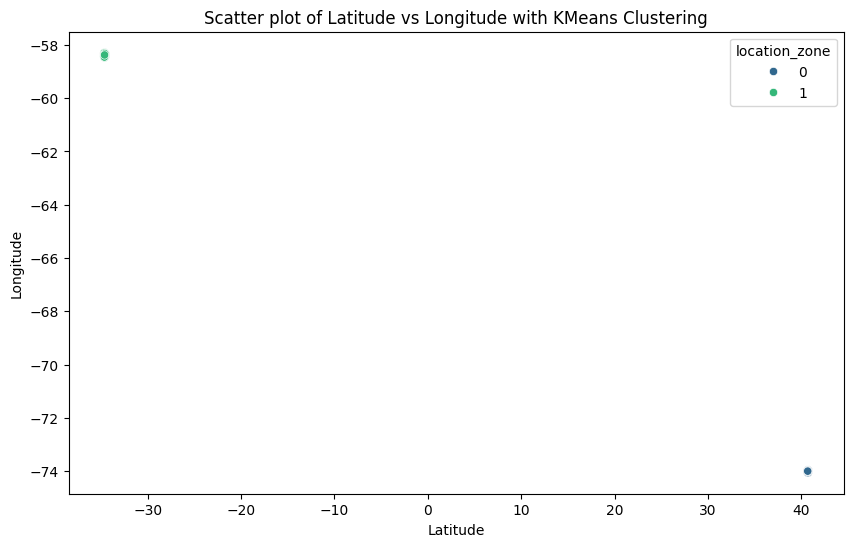

In [79]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=location_data, x='lat', y='lon', hue='location_zone', palette='viridis')
plt.title('Scatter plot of Latitude vs Longitude with KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


## Punto 4.2

In [80]:
import numpy as np
from models.clustering.kmeans import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


results_engineering = train_and_evaluate_model(
    df=processed_df, 
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_engineering = results_engineering["model"]


=== Model Evaluation (LinearRegressor) ===
MSE: 0.012801
R2: 0.978757
MAE: 0.078409
Método: pseudo_inverse
Intercept: 5.6177

Coeficientes:
------------------------------
area            | +0.0108
is_house        | +0.2451
has_pool        | +0.1224
age             | -0.0080
rooms           | +0.0104
location_zone   | -1.4821
area_per_room   | -0.0007
pool_house      | -0.0151
house_area      | -0.0015


In [81]:
# figures_engineering = visualize_regression_results(
#     results_engineering['y_test'],
#     results_engineering['y_pred_test'],
#     transform_func=np.exp,
#     fig_size=(12, 6),
#     titles=custom_titles,
#     show_figures=True,
#     fit_degree=1
# )

### Punto 4.3

In [82]:
df = pd.read_csv(r"../data/processed/casas_dev.csv")

df_numeric = df.select_dtypes(include=['float64', 'int64']).columns

feature_ops = []
features_count = 0
powers = range(1, 40)  

for col in df_numeric:
    for power in powers:
        if features_count >= 300:
            break
            
        feature_ops.append({
            'name': f'{col}_power_{power}',
            'operation': lambda df, col=col, power=power: df[col] ** power
        })
        features_count += 1
        
    if features_count >= 300:
        break

# kmeans = KMeans(n_clusters=2)
results = process_dataset(
    df=df,
    kmeans_model=kmeans,
    feature_engineering_ops=feature_ops,
    location_columns=None,
    features_to_impute=['age', 'rooms']
    )

processed_df = results['df']

processed_df.head()

,area,is_house,has_pool,age,price,lat,lon,rooms,area_power_1,area_power_2,...,rooms_power_18,rooms_power_19,rooms_power_20,rooms_power_21,rooms_power_22,rooms_power_23,rooms_power_24,rooms_power_25,rooms_power_26,rooms_power_27
0,58.993405,1,0,18.0,546.0,40.679064,-74.007844,2.0,58.993405,3480.221833,...,2.621440e+05,5.242880e+05,1.048576e+06,2.097152e+06,4.194304e+06,8.388608e+06,1.677722e+07,3.355443e+07,6.710886e+07,1.342177e+08
1,102.007494,0,0,9.0,759.0,40.712839,-73.967750,3.0,102.007494,10405.528832,...,3.874205e+08,1.162261e+09,3.486784e+09,1.046035e+10,3.138106e+10,9.414318e+10,2.824295e+11,8.472886e+11,2.541866e+12,7.625597e+12
2,61.966301,0,0,7.0,464.0,40.669863,-74.029414,2.0,61.966301,3839.822460,...,2.621440e+05,5.242880e+05,1.048576e+06,2.097152e+06,4.194304e+06,8.388608e+06,1.677722e+07,3.355443e+07,6.710886e+07,1.342177e+08
3,127.000000,1,1,16.0,251.0,-34.600437,-58.415266,4.0,127.000000,16129.000000,...,6.871948e+10,2.748779e+11,1.099512e+12,4.398047e+12,1.759219e+13,7.036874e+13,2.814750e+14,1.125900e+15,4.503600e+15,1.801440e+16
4,128.020334,0,0,8.0,963.0,40.722322,-73.983229,4.0,128.020334,16389.205917,...,6.871948e+10,2.748779e+11,1.099512e+12,4.398047e+12,1.759219e+13,7.036874e+13,2.814750e+14,1.125900e+15,4.503600e+15,1.801440e+16


In [83]:

results_300 = train_and_evaluate_model(
    df=processed_df, 
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae'],
    verbose=False
)

mse_300 = results_300["mse"]
r2_300 = results_300["r2"]
mae_300 = results_300["mae"]

print(f"Mean Squared Error: {mse_300:.2f}")
print(f"R2 Score: {r2_300:.2f}")
print(f"Mean Absolute Error: {mae_300:.2f}")

Mean Squared Error: 35.77
R2 Score: -58.37
Mean Absolute Error: 5.93


Se esperaba que la incorporación masiva de 300 features, generadas como potencias de las variables numéricas originales, empeorara drásticamente el desempeño del modelo. En lugar de aportar información útil, estas transformaciones generan variables altamente correlacionadas y redundantes, lo que conduce a sobreajuste, inestabilidad numérica y problemas de interpretación, haciendo que el modelo ande mal. Los resultados—con un MSE de 35.77, un R² de -58.37 y un MAE de 5.93—confirman que esta estrategia no tiene sentido, ya que agranda la dimensión del problema sin aportar mejoras predictivas, sino que, por el contrario, deteriora significativamente la calidad del modelo.

# Punto 5


## Punto 5.1 - 5.3

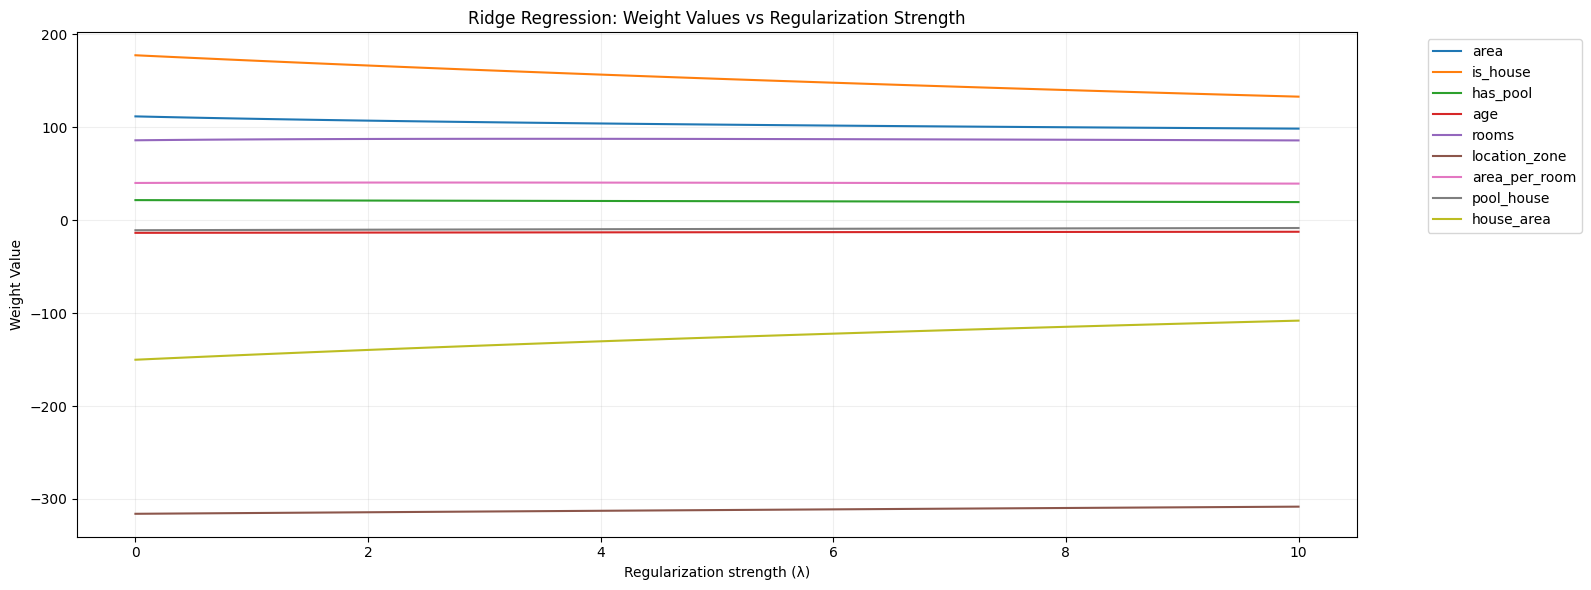

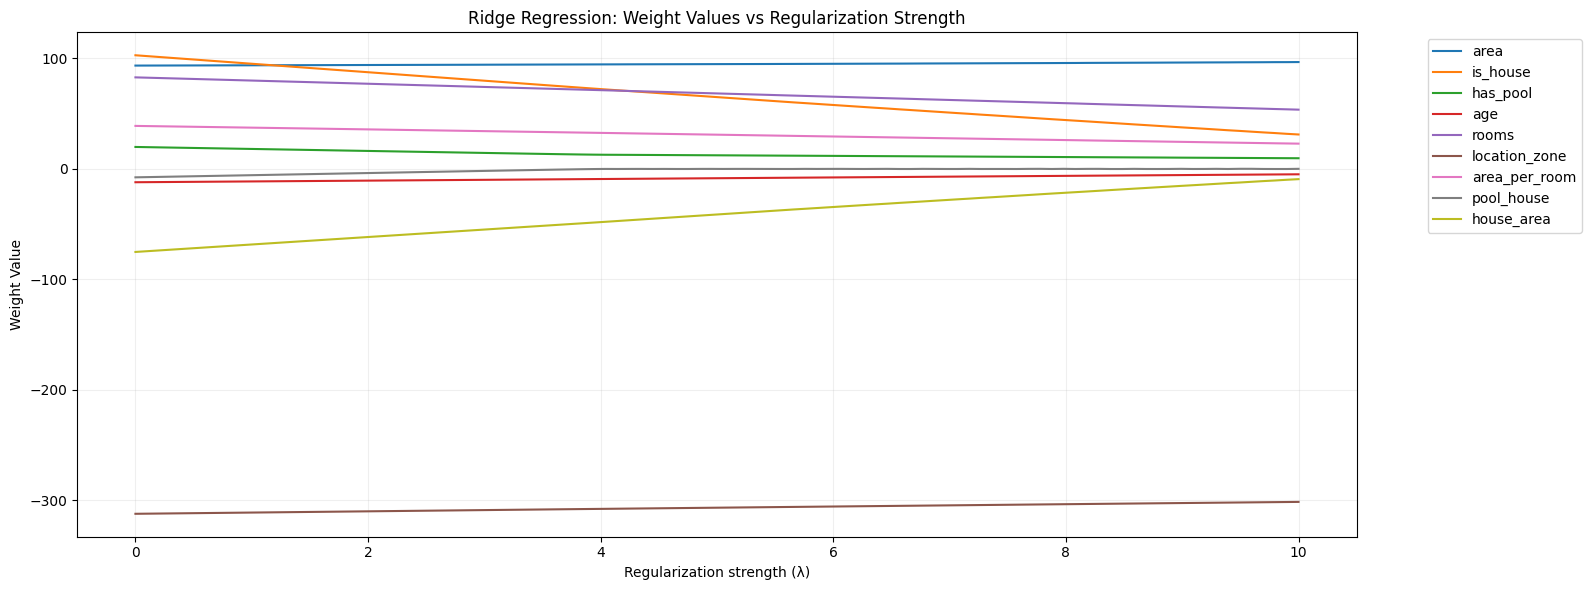

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.regression.linear_regressor import LinearRegressor
from utils.model import get_weights_and_metrics
from utils.visuals import plot_weights_vs_lambda, plot_performance_metrics


df = pd.read_csv(r"../data/processed/casas_dev_eng.csv")

X = df.drop('price', axis=1)
y = df['price']


lambdas = np.linspace(0, 10, 100)


weights_ridge, mse_scores_ridge, r2_scores_ridge = get_weights_and_metrics(X, y, lambdas, LinearRegressor, normalize=True, method='pseudo_inverse', regularization='l2',random_state=12)
weights_lasso, mse_scores_lasso, r2_scores_lasso = get_weights_and_metrics(X, y, lambdas, LinearRegressor, normalize=True, method='gradient_descent', regularization='l1',random_state=12)

feature_names = X.columns


plot_weights_vs_lambda(lambdas, weights_ridge, feature_names)
plot_weights_vs_lambda(lambdas, weights_lasso, feature_names)




El uso de regularización L1 (Lasso) y L2 (Ridge) tiene efectos distintos en los coeficientes del modelo: Lasso tiende a llevar varios coeficientes exactamente a cero, lo que implica una selección de variables automática y favorece la interpretabilidad del modelo, mientras que Ridge reduce gradualmente la magnitud de todos los coeficientes sin anularlos, distribuyendo el peso entre las variables y haciendo el modelo más estable cuando hay colinealidad. Así, Lasso es útil cuando se busca un modelo más simple y con menos variables relevantes, mientras que Ridge es preferible cuando todas las variables contienen información importante y se quiere evitar sobreajuste sin eliminar ninguna.

## Punto 5.4

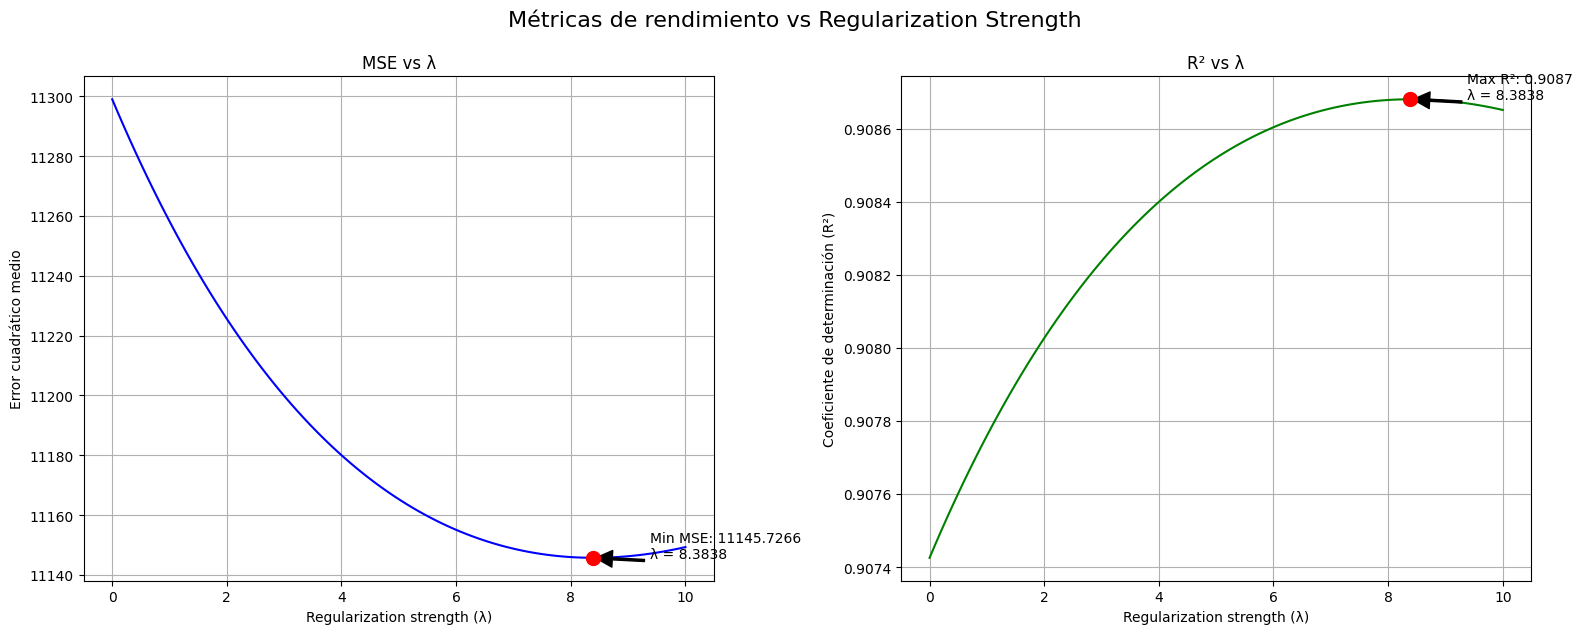

In [85]:
# El mínimo/máximo es el mismo lambda porque...
min_lambda_ridge, min_mse_ridge, max_lambda_ridge, max_r2_ridge = plot_performance_metrics(lambdas, mse_scores_ridge, r2_scores_ridge)


In [86]:
from utils.model import train_and_evaluate_model

df = pd.read_csv(r"../data/processed/casas_dev_eng.csv")    

results_ridge = train_and_evaluate_model(
    df = df,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse',
                'alpha': min_lambda_ridge,
                'regularization': 'l2'
                },
    metrics=['mse', 'r2', 'mae']
    )



=== Model Evaluation (LinearRegressor) ===
MSE: 11664.257232
R2: 0.904432
MAE: 74.616519
Método: ridge_analytical
Intercept: 56.0858

Coeficientes:
------------------------------
area            | +4.1091
is_house        | +218.5085
has_pool        | +39.9333
age             | -2.4325
rooms           | +56.9265
location_zone   | -587.8357
area_per_room   | +4.7808
pool_house      | -12.4254
house_area      | -1.8217


## Punto 5.6

In [ ]:
def plot_cross_validation_mse_vs_lambda(X, y, lambdas, model_class, n_splits=5, 
                                       method='pseudo_inverse', regularization='l2', 
                                       normalize=True, random_state=None, 
                                       title=None, ax=None):
   
    # Implementar KFold casero usando numpy
    def numpy_kfold(n_samples, n_splits, random_state=None):
        # Configurar generador de números aleatorios
        if random_state is not None:
            np.random.seed(random_state)
        
        # Crear índices y mezclarlos
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        
        # Calcular tamaño aproximado de cada fold
        fold_size = n_samples // n_splits
        
        # Generar los índices de train y test para cada fold
        for i in range(n_splits):
            # Índices para el set de validación
            start = i * fold_size
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            val_indices = indices[start:end]
            
            # Índices para el set de entrenamiento
            train_indices = np.concatenate([indices[:start], indices[end:]])
            
            yield train_indices, val_indices
    
    cv = numpy_kfold(len(X), n_splits, random_state)
    
    cv_mse_scores = []
    std_scores = []
    
    # Para cada valor de lambda, calcular el ECM mediante validación cruzada
    for lambda_val in lambdas:
        fold_scores = []
        
        for train_idx, val_idx in cv:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if normalize:
                X_train = (X_train - X_train.mean()) / X_train.std()
                X_val = (X_val - X_train.mean()) / X_train.std()
            
            model = model_class()
            
            model.fit(X_train, y_train,
                     method=method,
                     alpha=lambda_val,
                     regularization=regularization
 )
            
            y_pred = model.predict(X_val)
            
            # Calcular MSE en este fold
            mse = model.mse_score(y_val, y_pred)
            r2 = model.r2_score(y_val, y_pred)
            fold_scores.append((mse, r2))
        
        # Extraer solo los valores MSE y calcular estadísticas
        mse_values = np.array([score[0] for score in fold_scores])
        cv_mse_scores.append(np.mean(mse_values))
        std_scores.append(np.std(mse_values))
    
    cv_mse_scores = np.array(cv_mse_scores)
    std_scores = np.array(std_scores)
    
    # Encontrar el lambda óptimo
    min_cv_mse_idx = np.argmin(cv_mse_scores)
    min_cv_mse = cv_mse_scores[min_cv_mse_idx]
    optimal_lambda = lambdas[min_cv_mse_idx]
    
    # Crear gráfico
    if ax is None:
        plt.figure(figsize=(12, 7))
        ax = plt.gca()
    
    # Configurar estilo de seaborn
    sns.set_style("whitegrid")
    
    # Graficar MSE medio con bandas de error
    ax.plot(lambdas, cv_mse_scores, color='blue', label='$ECM$ promedio')
    ax.fill_between(
        lambdas, 
        cv_mse_scores - std_scores, 
        cv_mse_scores + std_scores, 
        color='blue', 
        alpha=0.2,
        label=r'$\pm$ 1 desv. estándar'
    )
    
    # Marcar el lambda óptimo
    ax.axvline(x=optimal_lambda, color='red', linestyle='--', alpha=0.7)
    ax.scatter([optimal_lambda], [min_cv_mse], color='red', s=100, zorder=5)
    ax.annotate(
        r'$ECM_{{\min}}: {min_cv_mse:.4f}$\n$\\lambda = {optimal_lambda:.4f}$'.format(
            min_cv_mse=min_cv_mse, optimal_lambda=optimal_lambda
        ),
        xy=(optimal_lambda, min_cv_mse),
        xytext=(optimal_lambda+1, min_cv_mse),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
        fontsize=12
    )
    
    # Configurar etiquetas y título
    ax.set_xlabel(r'Intensidad de regularización ($\\lambda$)', fontsize=12)
    ax.set_ylabel(r'Error Cuadrático Medio ($ECM$) - Validación Cruzada', fontsize=12)
    
    if title is None:
        title = r'Validación Cruzada ({n_splits} folds): $ECM$ vs $\\lambda$'.format(n_splits=n_splits)
    ax.set_title(title, fontsize=14)
    
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return optimal_lambda, min_cv_mse, cv_mse_scores, std_scores


# use

df = pd.read_csv(r"../data/processed/casas_dev_eng.csv")

X = df.drop('price', axis=1)
y = df['price']

lambdas = np.linspace(0, 10, 100)

optimal_lambda, min_cv_mse, cv_mse_scores, std_scores = plot_cross_validation_mse_vs_lambda(
    X, y, lambdas, LinearRegressor, n_splits=5, method='pseudo_inverse', regularization='l2', normalize=True, random_state=12
)



<>:115: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\m'
/var/folders/d3/lp38b7ms0ynbmnnz4lckj0g80000gn/T/ipykernel_56610/211958998.py:115: SyntaxWarning: invalid escape sequence '\m'
  f'$ECM_{{{{\min}}}}: {min_cv_mse:.4f}$\n$\\lambda = {optimal_lambda:.4f}$',
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/sit

Error in callback <function _draw_all_if_interactive at 0x126c91800> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
Intensidad de regularización ($\\lambda$)
                              ^
ParseException: Expected end of text, found '$'  (at char 30), (line:1, col:31)

ValueError: 
Intensidad de regularización ($\\lambda$)
                              ^
ParseException: Expected end of text, found '$'  (at char 30), (line:1, col:31)

<Figure size 1200x700 with 1 Axes>

# FINAL

In [ ]:
df = pd.read_csv(r"../data/raw/casas_test.csv")

df.isna().sum()

area           0
area_units     0
is_house       0
has_pool       0
age           16
price          0
lat            0
lon            0
rooms          4
dtype: int64

In [ ]:
# Load the test data
df = pd.read_csv(r"../data/raw/casas_test.csv")

# Apply the same preprocessing steps
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'
df['location_zone'] = kmeans.predict(df[['lat', 'lon']].to_numpy())

df['area_per_room'] = df['area'] / df['rooms']
df['pool_house'] = df['has_pool'] * df['is_house']

df = df.drop('area_units', axis=1)

# Save the processed test data
df.to_csv(r"../data/processed/casas_test.csv", index=False)


In [ ]:
#insertar la media de age y rooms dependiendo de location zone (0 y 1)
df = pd.read_csv(r"../data/processed/casas_test.csv")

df_0 = df[df['location_zone'] == 0]
df_1 = df[df['location_zone'] == 1]


mean_age_0 = df_0['age'].mean()
mean_rooms_0 = df_0['rooms'].mean()

mean_age_1 = df_1['age'].mean()
mean_rooms_1 = df_1['rooms'].mean()

df.loc[df['location_zone'] == 0, 'age'] = df['age'].fillna(mean_age_0)
df.loc[df['location_zone'] == 0, 'rooms'] = df['rooms'].fillna(mean_rooms_0)

df.loc[df['location_zone'] == 1, 'age'] = df['age'].fillna(mean_age_1)
df.loc[df['location_zone'] == 1, 'rooms'] = df['rooms'].fillna(mean_rooms_1)

df = df.drop(['lat', 'lon'], axis=1)

df.to_csv(r"../data/processed/casas_test.csv", index=False)

In [ ]:
X_test = df.drop('price', axis=1)


# Get the target variable
y_test = df['price']

# Apply log transformation to match training
y_test = np.log(y_test)

# Make predictions
y_pred_test = model_engineering.predict(X_test)
y_pred_test = np.exp(y_pred_test)  # Inverse transform predictions

# Calculate metrics
r2 = model_engineering.r2_score(X_test, y_test)
print("R² Score:", r2)

ValueError: Número incorrecto de características. Esperado: 10, Recibido: 9